<div align="center"><h3>HW4, Question 3</h3></div>
<div align="center"><h5>Mohammadreza Ghofrani, 400131076</h5></div>

In [1]:
import scipy.io
from scipy.cluster import hierarchy
import numpy as np
import pandas as pd
import matplotlib.cm as cm
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

# Configuration Parameters

In [2]:
SAVE_FIGURE = False

# Initialization

In [3]:
rand_mat_dataset = scipy.io.loadmat('data/P3/rand.mat')['dataset'][0][0][0].T
gene_ex_dataset = pd.read_csv('data/P3/gene_ex.csv', header=None).to_numpy()
x_two_spiral_dataset, y_two_spiral_dataset = \
    scipy.io.loadmat('data/P3/two_spiral.mat')['dataset'][0][0][0].T, \
    scipy.io.loadmat('data/P3/two_spiral.mat')['dataset'][0][0][1][:, 0]

# Part A

In [4]:
def kmeans(x_train, k, centers=None):
    number_of_features = x_train.shape[0]
    number_of_data = x_train.shape[1]
    if centers is None:
        centers = x_train[:, np.random.choice(range(number_of_data), k, replace=False)]
    current_centers = centers
    distance_between_new_and_previous_centers = float("inf")
    while distance_between_new_and_previous_centers > 0.001:
        previous_centers = current_centers
        distances = np.zeros((k, number_of_data))
        for i, center in enumerate(centers.T):
            distances[i, :] = \
                np.sqrt(np.sum((x_train - center[np.newaxis].T)**2,
                               axis=0))
        y_predicted = np.argmin(distances, axis=0)
        centers = np.zeros((number_of_features,k))
        for i in range(k):
            centers[:, i] = np.mean(x_train[:, y_predicted==i], axis=1)
        current_centers = centers
        distance_between_new_and_previous_centers = \
            np.sqrt(np.sum((current_centers - previous_centers)**2))
    return centers, y_predicted

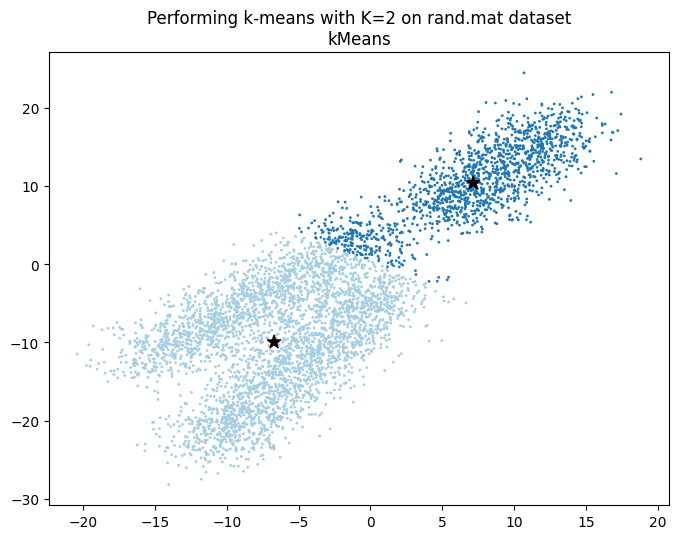

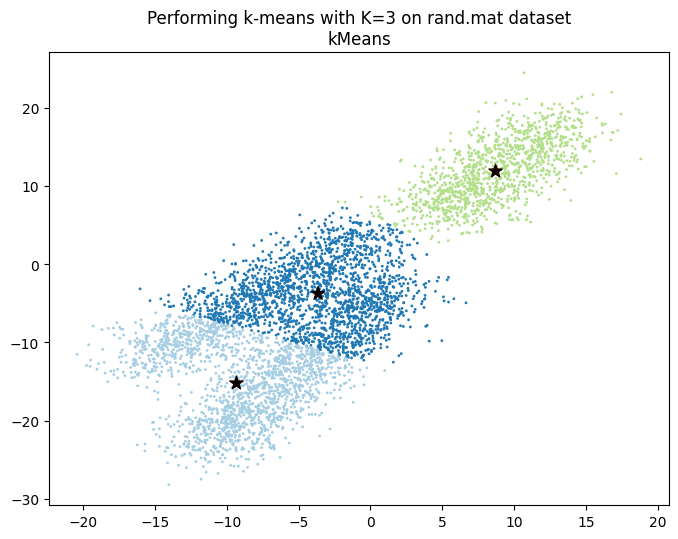

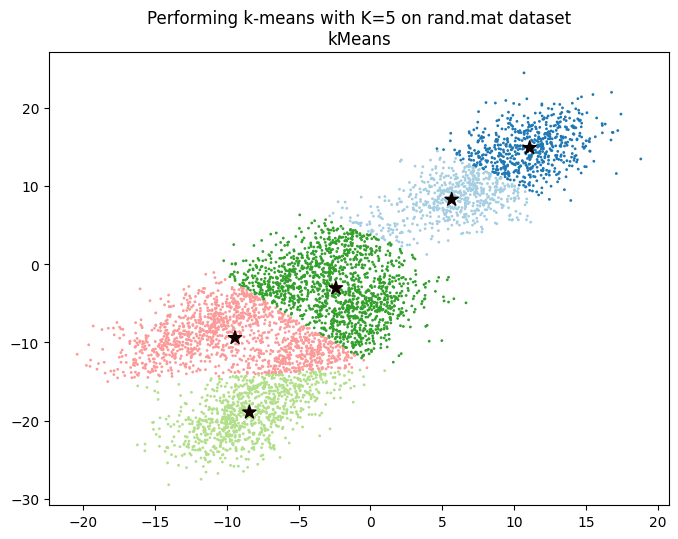

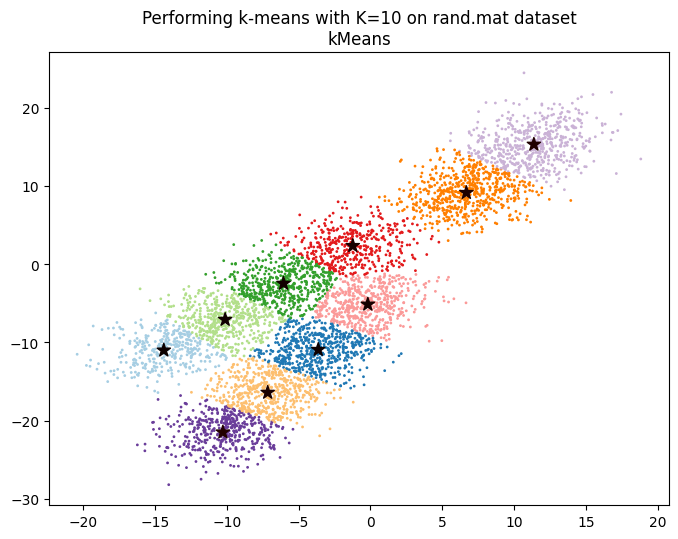

In [5]:
for k in [2, 3, 5, 10]:
    centers, y_predicted = kmeans(rand_mat_dataset, k)
    figure(figsize=(8, 6), dpi=100)
    plt.scatter(rand_mat_dataset[0,:], rand_mat_dataset[1,:], 
                color=cm.Paired(y_predicted), s=1)
    plt.scatter(centers[0, :], centers[1, :], 
                color=cm.hot(sorted(list(set(y_predicted)))), marker='*',
                s=100)
    plt.title(f'Performing k-means with K={k} on rand.mat dataset\nkMeans')
    if SAVE_FIGURE:
        plt.savefig(f'../images/q3/a/{k}.png')
    plt.show()

# Part B

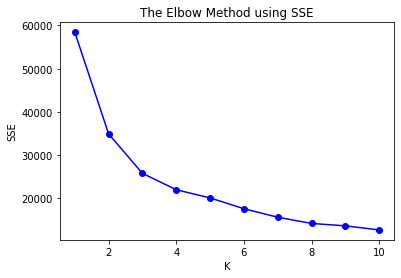

In [6]:
k_range = list(range(1,11))
sse_k = list()
for k in k_range:
    centers, y_predicted = kmeans(rand_mat_dataset, k)
    sse = 0
    for y in set(y_predicted):
        sse += np.sum(
            np.sqrt(np.sum((rand_mat_dataset[:, y_predicted==y] - centers[:, y][np.newaxis].T)**2,
                              axis=0))
            )
    sse_k.append(sse)
plt.plot(k_range, sse_k, 'bo-')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('The Elbow Method using SSE')
if SAVE_FIGURE:
        plt.savefig(f'../images/q3/b/elbow.png')
plt.show()

# Part C

In [7]:
def kmedoid(x_train, k, centers=None):
    number_of_features = x_train.shape[0]
    number_of_data = x_train.shape[1]
    if centers is None:
        centers = x_train[:, np.random.choice(range(number_of_data), k, replace=False)]
    current_centers = centers
    distance_between_new_and_previous_centers = float("inf")
    while distance_between_new_and_previous_centers > 0.001:
        previous_centers = current_centers
        distances = np.zeros((k, number_of_data))
        for i, center in enumerate(centers.T):
            distances[i, :] = \
                np.sqrt(np.sum((x_train - center[np.newaxis].T)**2,
                               axis=0))
        y_predicted = np.argmin(distances, axis=0)
        centers = np.zeros((number_of_features,k))
        for y in set(y_predicted):
            x_cluster = x_train[:, y_predicted==y]
            index_of_element_causes_min_distance = None
            min_distance_from_cluster_elements = float("inf")
            for i, x in enumerate(x_cluster.T):
                distance_from_cluster_elements = \
                    np.sum(
                        np.sqrt(np.sum((x_cluster - x[np.newaxis].T)**2, axis=0))
                    )
                if min_distance_from_cluster_elements > distance_from_cluster_elements:
                    min_distance_from_cluster_elements = distance_from_cluster_elements
                    index_of_element_causes_min_distance = i
            centers[:, y] = x_cluster[:, index_of_element_causes_min_distance]
        current_centers = centers
        distance_between_new_and_previous_centers = \
            np.sqrt(np.sum((current_centers - previous_centers)**2))
    return centers, y_predicted

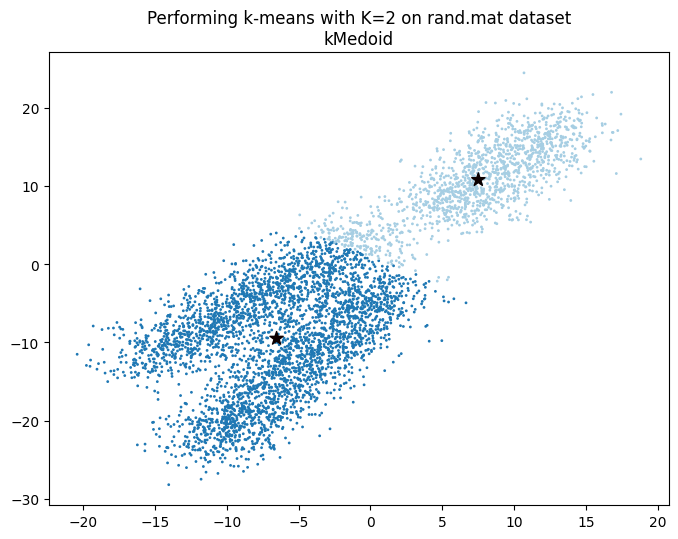

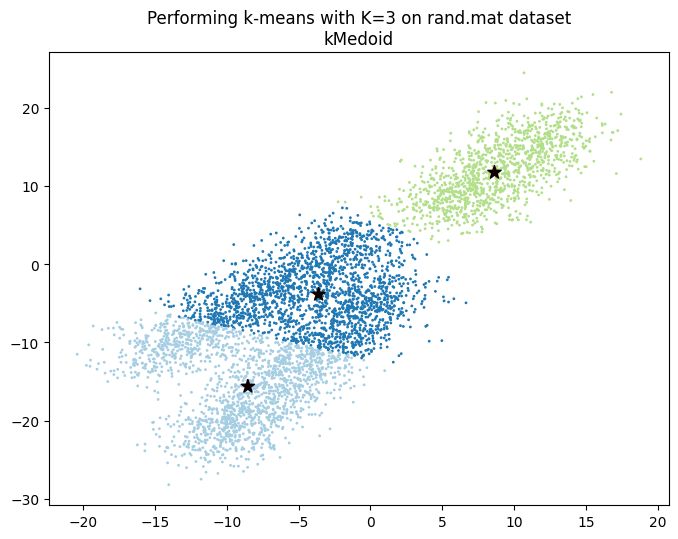

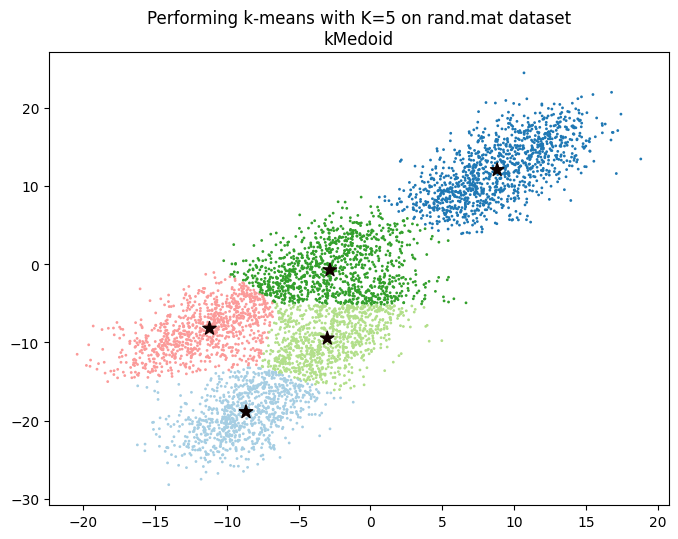

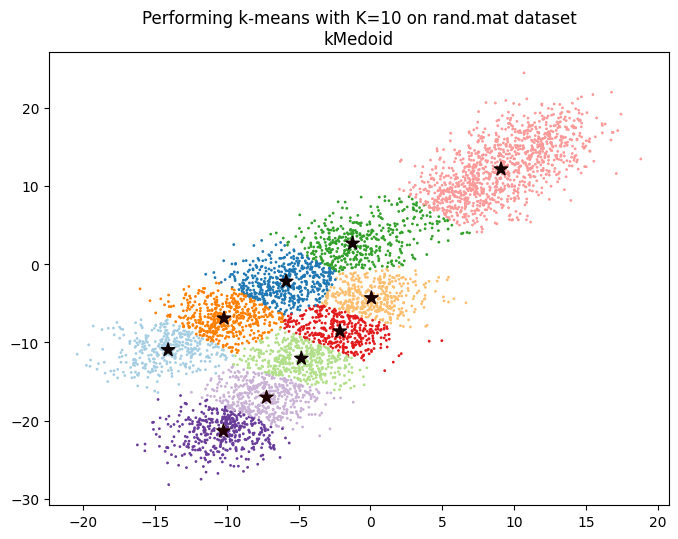

In [8]:
for k in [2, 3, 5, 10]:
    centers, y_predicted = kmedoid(rand_mat_dataset, k)
    figure(figsize=(8, 6), dpi=100)
    plt.scatter(rand_mat_dataset[0,:], rand_mat_dataset[1,:], 
                color=cm.Paired(y_predicted), s=1)
    plt.scatter(centers[0, :], centers[1, :], 
                color=cm.hot(sorted(list(set(y_predicted)))), marker='*',
                s=100)
    plt.title(f'Performing k-means with K={k} on rand.mat dataset\nkMedoid')
    if SAVE_FIGURE:
        plt.savefig(f'../images/q3/c/{k}.png')
    plt.show()

# Part D

In [9]:
def heirarchy_clustering(x_train, metric='euclidean', linkage='single'):
    n = x_train.shape[1]
    cluster = {i:[i] for i in range(n)}
    merging_clusters = {}
    Z_index_interpreter = list(range(n))
    Z = np.zeros((n-1, 4))
    if linkage == 'single':
        merging_function = np.minimum
    elif linkage == 'complete':
        merging_function = np.maximum
    else:
        raise 'linkage not supported'

    distance_matrix = squareform(pdist(x_train.T, metric=metric))
    np.fill_diagonal(distance_matrix, np.nan)
    for i in range(n-1):
        index_node1, index_node2 = \
            np.unravel_index(np.nanargmin(distance_matrix), distance_matrix.shape)

        value_node1, value_node2 = \
            Z_index_interpreter[index_node1], Z_index_interpreter[index_node2]
        Z_index_interpreter.pop(index_node1)
        Z_index_interpreter.pop(index_node2-1)
        Z_index_interpreter.append(n+i)

        cluster[n+i] = cluster[value_node1] + cluster[value_node2]
        merging_clusters[n+i] = (value_node1, value_node2)

        Z[i] = \
            np.array([
                value_node1, 
                value_node2,
                distance_matrix[index_node1, index_node2],
                len(cluster[n+i])
            ])

        node1_distances = distance_matrix[index_node1]
        node2_distances = distance_matrix[index_node2]

        mask_1d = \
            (np.arange(len(node1_distances))!=index_node1) & \
            (np.arange(len(node2_distances))!=index_node2)

        node1_distances = node1_distances[mask_1d]
        node2_distances = node2_distances[mask_1d]
        new_node_distances = merging_function(node1_distances, node2_distances)
        distance_matrix_tmp = distance_matrix[:, mask_1d][mask_1d, :]
        distance_matrix_tmp = \
            np.hstack((distance_matrix_tmp, new_node_distances[np.newaxis].T))
        distance_matrix = \
            np.vstack(
                (distance_matrix_tmp, np.hstack((new_node_distances, float('inf'))))
                )
    return Z, cluster, merging_clusters

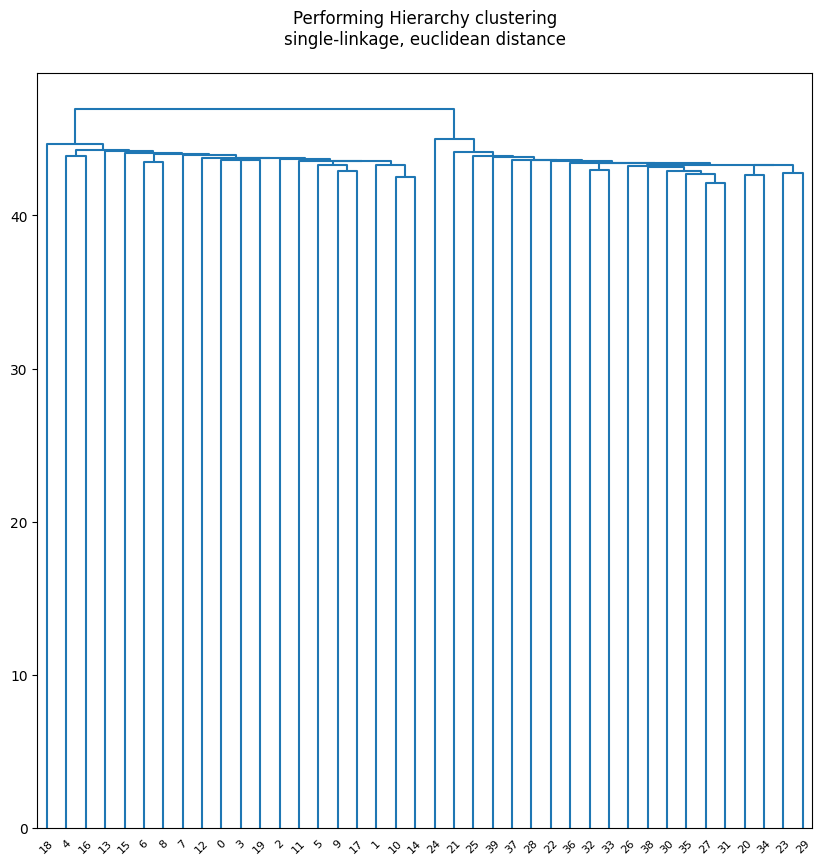

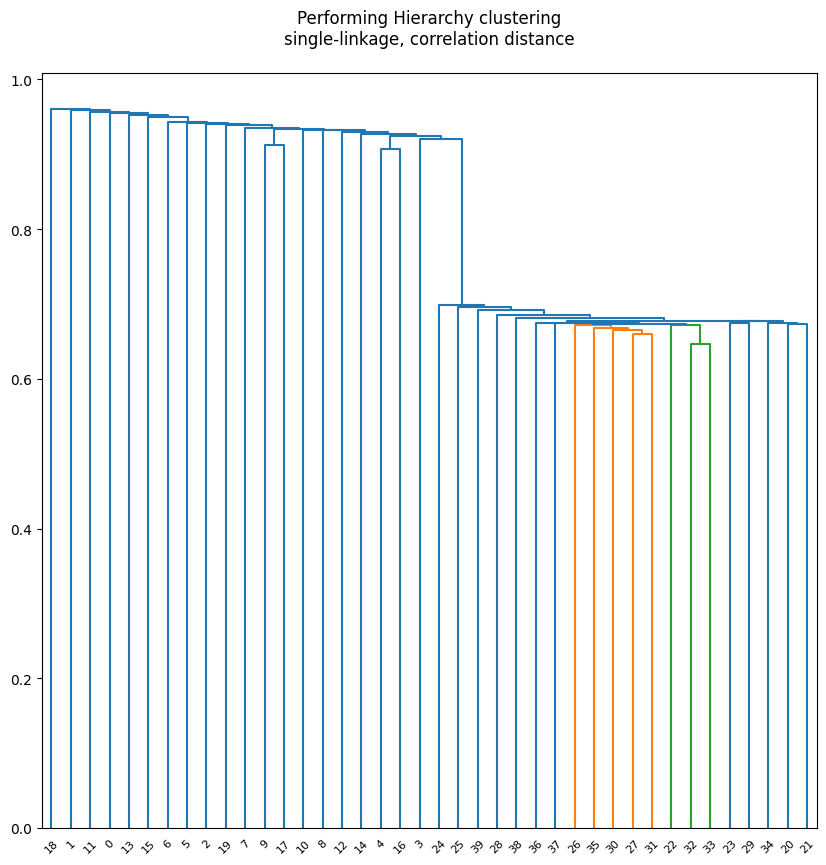

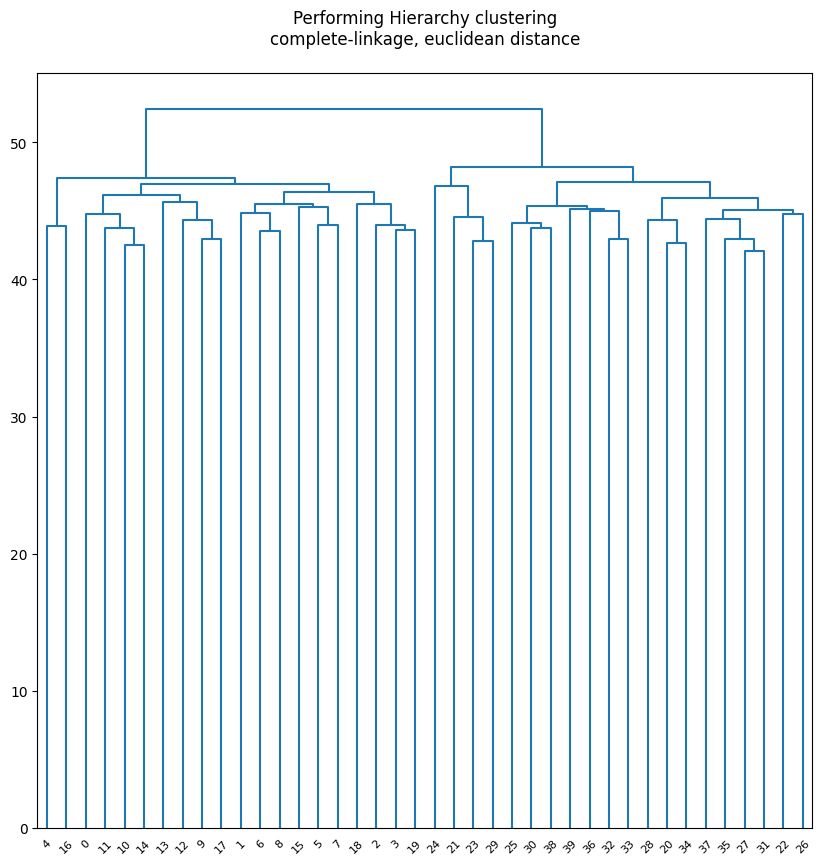

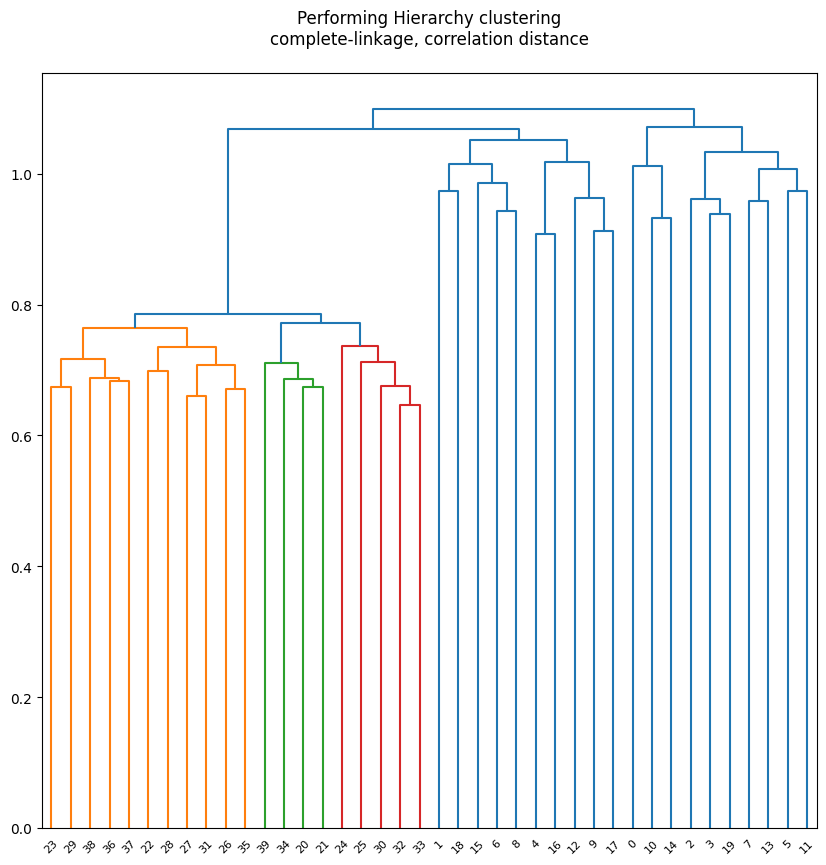

In [10]:
for linkage in ['single', 'complete']:
    for metric in ['euclidean', 'correlation']:
        Z, _, _ = heirarchy_clustering(gene_ex_dataset, metric=metric, linkage=linkage)
        figure(figsize=(10, 10), dpi=100)
        dn = hierarchy.dendrogram(Z)
        plt.title(f'Performing Hierarchy clustering\n'
                  f'{linkage}-linkage, {metric} distance\n')
        if SAVE_FIGURE:
            plt.savefig(f'../images/q3/d/{linkage}_{metric}.png')
        plt.show()

# Part F

In [11]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

In [12]:
_, y_predicted = kmeans(x_two_spiral_dataset, k=2)
y_predicted += 1
print(f'kMeans')
print(f'Purity score:'
      f'{purity_score(y_two_spiral_dataset, y_predicted)}')
print(f'NMI score'
      f'{metrics.normalized_mutual_info_score(y_two_spiral_dataset, y_predicted)}')

kMeans
Purity score:0.5935
NMI score0.025412392639248924


In [13]:
for linkage in ['single', 'complete']:
    Z, cluster, merging_clusters = \
        heirarchy_clustering(x_two_spiral_dataset, linkage=linkage)
    y_predicted = np.ones(y_two_spiral_dataset.shape)
    cluster1, cluster2 = merging_clusters[max(merging_clusters.keys())]
    y_predicted[cluster[cluster2]] += 1
    print(f'{linkage}-linkage')
    print(f'Purity score:'
          f'{purity_score(y_two_spiral_dataset, y_predicted)}')
    print(f'NMI score:'
          f'{metrics.normalized_mutual_info_score(y_two_spiral_dataset, y_predicted)}')

single-linkage
Purity score:1.0
NMI score:1.0
complete-linkage
Purity score:0.6045
NMI score:0.036320148104460596
